## Importing stuff

## Define some local functions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm

import iris
import iris.plot as iplt
import iris.coord_categorisation

from FLO_utils import extract_cube_area, add_bounds, __callback_add_forecast_day
from RH_wrt_water import RH_wrt_water_from_cubes

In [2]:
def split(full_dataset, val_percent, test_percent, random_seed=None):
    amount = len(full_dataset)

    test_amount = (
        int(amount * test_percent)
        if test_percent is not None else 0)
    val_amount = (
        int(amount * val_percent)
        if val_percent is not None else 0)
    train_amount = amount - test_amount - val_amount

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        (train_amount, val_amount, test_amount),
        generator=(
            torch.Generator().manual_seed(random_seed)
            if random_seed
            else None))
    
    return train_dataset, val_dataset, test_dataset


def calc_cube_daymean(cube):
    cube_daymean = cube.copy()
    aux_coord_names = [coord.name() for coord in cube.aux_coords]

    if "year" not in aux_coord_names:
        iris.coord_categorisation.add_year(cube, 'time')
        
    if "day_of_year" not in aux_coord_names:   
        iris.coord_categorisation.add_day_of_year(cube, 'time')
        
    cube_daymean = cube.aggregated_by(['year', 'day_of_year'], iris.analysis.MEAN)
    
    return cube_daymean

## Loading Data

In [3]:
AQUM_PATH = "/scratch/fmalavel/mass_retrievals/u-df278/"
AQUM_files = ["*202203*.pp", "*202206*.pp"]
#AQUM_files = ["*2022033*.pp"]
AQUM_filelist = [AQUM_PATH + x for x in AQUM_files]
print(f"\n{AQUM_filelist}")

all_cubes = iris.load(AQUM_filelist, None, __callback_add_forecast_day )#, time_constraint)
print(f"\n{all_cubes}")

# Thermodynamics Constraints
t_con = iris.AttributeConstraint(STASH='m01s00i004')
q_con = iris.AttributeConstraint(STASH='m01s00i010')
p_con = iris.AttributeConstraint(STASH='m01s00i408')

# PM Constraints
pm10wet_con = iris.AttributeConstraint(STASH='m01s38i560')
pm2p5wet_con = iris.AttributeConstraint(STASH='m01s38i561')
pm10dry_con = iris.AttributeConstraint(STASH='m01s38i562')
pm2p5dry_con = iris.AttributeConstraint(STASH='m01s38i563')

# GLOMAP MMR Constraints
ait_ins_bc_con = iris.AttributeConstraint(STASH='m01s34i120')
ait_ins_om_con = iris.AttributeConstraint(STASH='m01s34i121')
ait_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i104')
ait_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i105')
ait_sol_om_con = iris.AttributeConstraint(STASH='m01s34i106')
ait_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i137')
ait_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i133')
acc_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i108')
acc_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i109')
acc_sol_om_con = iris.AttributeConstraint(STASH='m01s34i110')
acc_sol_ss_con = iris.AttributeConstraint(STASH='m01s34i111')
acc_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i138')
acc_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i134')
coa_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i114')
coa_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i115')
coa_sol_om_con = iris.AttributeConstraint(STASH='m01s34i116')
coa_sol_ss_con = iris.AttributeConstraint(STASH='m01s34i117')
coa_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i139')
coa_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i135')

# GLOMAP Number Constraints
ait_sol_number_con = iris.AttributeConstraint(STASH='m01s34i103')
acc_sol_number_con = iris.AttributeConstraint(STASH='m01s34i107')
coa_sol_number_con = iris.AttributeConstraint(STASH='m01s34i113')
ait_ins_number_con = iris.AttributeConstraint(STASH='m01s34i119')

# Time constratints
fcst_day_cons = iris.Constraint(forecast_day=1)

# Loading Specific cubes ...

# Thermodynamics
theta = all_cubes.extract_cube(t_con & fcst_day_cons)
p =  all_cubes.extract_cube(p_con & fcst_day_cons)
q = all_cubes.extract_cube(q_con & fcst_day_cons)

# PM
pm10wet = all_cubes.extract_cube(pm10wet_con & fcst_day_cons)
pm10dry = all_cubes.extract_cube(pm10dry_con & fcst_day_cons)
pm2p5wet = all_cubes.extract_cube(pm2p5wet_con & fcst_day_cons)
pm2p5dry = all_cubes.extract_cube(pm2p5dry_con & fcst_day_cons)

# Mode MMRs
ait_ins_bc = all_cubes.extract_cube(ait_ins_bc_con & fcst_day_cons)
ait_ins_om = all_cubes.extract_cube(ait_ins_om_con & fcst_day_cons)
ait_sol_so4 = all_cubes.extract_cube(ait_sol_so4_con & fcst_day_cons)
ait_sol_bc = all_cubes.extract_cube(ait_sol_bc_con & fcst_day_cons)
ait_sol_om = all_cubes.extract_cube(ait_sol_om_con & fcst_day_cons)
ait_sol_no3 = all_cubes.extract_cube(ait_sol_no3_con & fcst_day_cons)
ait_sol_nh4 = all_cubes.extract_cube(ait_sol_nh4_con & fcst_day_cons)
acc_sol_so4 = all_cubes.extract_cube(acc_sol_so4_con & fcst_day_cons)
acc_sol_bc = all_cubes.extract_cube(acc_sol_bc_con & fcst_day_cons)
acc_sol_om = all_cubes.extract_cube(acc_sol_om_con & fcst_day_cons)
acc_sol_ss = all_cubes.extract_cube(acc_sol_ss_con & fcst_day_cons)
acc_sol_no3 = all_cubes.extract_cube(acc_sol_no3_con & fcst_day_cons)
acc_sol_nh4 = all_cubes.extract_cube(acc_sol_nh4_con & fcst_day_cons)
coa_sol_so4 = all_cubes.extract_cube(coa_sol_so4_con & fcst_day_cons)
coa_sol_bc = all_cubes.extract_cube(coa_sol_bc_con & fcst_day_cons)
coa_sol_om = all_cubes.extract_cube(coa_sol_om_con & fcst_day_cons)
coa_sol_ss = all_cubes.extract_cube(coa_sol_ss_con & fcst_day_cons)
coa_sol_no3 = all_cubes.extract_cube(coa_sol_no3_con & fcst_day_cons)
coa_sol_nh4 = all_cubes.extract_cube(coa_sol_nh4_con & fcst_day_cons)

# Mode Numbers
ait_sol_number = all_cubes.extract_cube(ait_sol_number_con & fcst_day_cons)
acc_sol_number = all_cubes.extract_cube(acc_sol_number_con & fcst_day_cons)
coa_sol_number = all_cubes.extract_cube(coa_sol_number_con & fcst_day_cons)
ait_ins_number = all_cubes.extract_cube(ait_ins_number_con & fcst_day_cons)

print(f"\n{pm2p5dry}")


['/scratch/fmalavel/mass_retrievals/u-df278/*202203*.pp', '/scratch/fmalavel/mass_retrievals/u-df278/*202206*.pp']


/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))



0: number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air / (1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
1: mass_fraction_of_sulfuric_acid_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
2: mass_fraction_of_black_carbon_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
3: mass_fraction_of_particulate_organic_matter_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
4: number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air / (1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
5: mass_fraction_of_sulfuric_acid_in_soluble_accumulation_mode_dry_aerosol_in_air / (kg kg-1) (time: 1416; grid_latitude: 182; grid_longitude: 146)
6: mass_fraction_of_black_carbon_in_soluble_accumulation_mode_dry_aerosol_in_air / (kg kg-1) (time: 1416; grid_latitude: 182; grid_

## Process cubes

In [4]:
# Calculate rh
rhw = RH_wrt_water_from_cubes(theta=theta, p=p, q=q)

# Combine Mode MMRs into one cube
modes_ait = (pm2p5dry).copy()
modes_acc = (pm2p5dry).copy()
modes_coa = (pm2p5dry).copy()
modes_all = (pm2p5dry).copy()

modes_ait.data = modes_ait.data * 0.0
modes_acc.data = modes_acc.data * 0.0
modes_coa.data = modes_coa.data * 0.0
modes_all.data = modes_all.data * 0.0

rho_air = 1.25  # assumes pho_air is 1.25 kg/m3
kgkg_to_ugm3 = rho_air * 1e9     # convert mmr to concentration
g_to_kg = 1e-3
m3_to_cm3 = 1e6

modes_ait.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data) * kgkg_to_ugm3

modes_acc.data = \
        (acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data) * kgkg_to_ugm3

modes_coa.data = \
        (coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3

modes_all.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data + \
        acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data + \
        coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3

modes_ait.units = "ug.m-3"
modes_acc.units = "ug.m-3"
modes_coa.units = "ug.m-3"
modes_all.units = "ug.m-3"


# Convert the NMR expressed as (mol/mol) to number/cm3 
boltzmann       = 1.380649e-23
aird = 1013e2 / 282 / boltzmann

#ait_sol_number.data = ait_sol_number.data #* aird / m3_to_cm3
#acc_sol_number.data = ait_sol_number.data #* aird / m3_to_cm3
#coa_sol_number.data = coa_sol_number.data #* aird / m3_to_cm3
#ait_ins_number.data = ait_ins_number.data #* aird / m3_to_cm3
#ait_sol_number.units = "mol/mol"
#acc_sol_number.units = "mol/mol"
#coa_sol_number.units = "mol/mol"
#ait_ins_number.units = "mol/mol"


#add bounds and remove domain edges
add_bounds(rhw)
add_bounds(modes_ait)
add_bounds(modes_acc)
add_bounds(modes_coa)
add_bounds(modes_all)
add_bounds(pm10wet)
add_bounds(pm10dry)
add_bounds(pm2p5wet)
add_bounds(pm2p5dry)
add_bounds(ait_sol_number)
add_bounds(acc_sol_number)
add_bounds(coa_sol_number)
add_bounds(ait_ins_number)

domain_dict = {
    "MINLON":-8.5,
    "MAXLON":5.25,
    "MINLAT":48.75,
    "MAXLAT":60.5,
}

extract_rhw = extract_cube_area(calc_cube_daymean(rhw),
                                MINLON=domain_dict["MINLON"],
                                MAXLON=domain_dict["MAXLON"],
                                MINLAT=domain_dict["MINLAT"],
                                MAXLAT=domain_dict["MAXLAT"],
                               )
extract_pm2p5dry = extract_cube_area(calc_cube_daymean(pm2p5dry),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm2p5wet = extract_cube_area(calc_cube_daymean(pm2p5wet),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm10dry = extract_cube_area(calc_cube_daymean(pm10dry),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm10wet = extract_cube_area(calc_cube_daymean(pm10wet),
                                    MINLON=domain_dict["MINLON"],
                                    MAXLON=domain_dict["MAXLON"],
                                    MINLAT=domain_dict["MINLAT"],
                                    MAXLAT=domain_dict["MAXLAT"],
                                   )
extract_modes_ait = extract_cube_area(calc_cube_daymean(modes_ait),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_acc = extract_cube_area(calc_cube_daymean(modes_acc),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_coa = extract_cube_area(calc_cube_daymean(modes_coa),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_all = extract_cube_area(calc_cube_daymean(modes_all),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_ait_sol_number = extract_cube_area(calc_cube_daymean(ait_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_acc_sol_number = extract_cube_area(calc_cube_daymean(acc_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_coa_sol_number = extract_cube_area(calc_cube_daymean(coa_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_ait_ins_number = extract_cube_area(calc_cube_daymean(ait_ins_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )

print(f"\n{extract_pm2p5dry}")


Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ]

In [31]:
mean_ait_ins = np.mean(extract_ait_ins_number.data)
print(mean_ait_ins)
mean_ait_sol = np.mean(extract_ait_sol_number.data)
print(mean_ait_sol)
mean_acc_sol = np.mean(extract_acc_sol_number.data)
print(mean_acc_sol)

mean_modes_ait = np.mean(extract_modes_ait.data)
print(mean_modes_ait)
mean_modes_acc = np.mean(extract_modes_acc.data)
print(mean_modes_acc)
mean_modes_all = np.mean(extract_modes_all.data)
print(mean_modes_all)

5.0763485e-17
1.24543316e-17
1.5286652e-17
1.4592899
6.8207917
19.45963


## Plot inputs data

/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/coords.py:2234: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_year'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/coords.py:2234: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coord

Text(0.5, 1.0, 'pm10 wet')

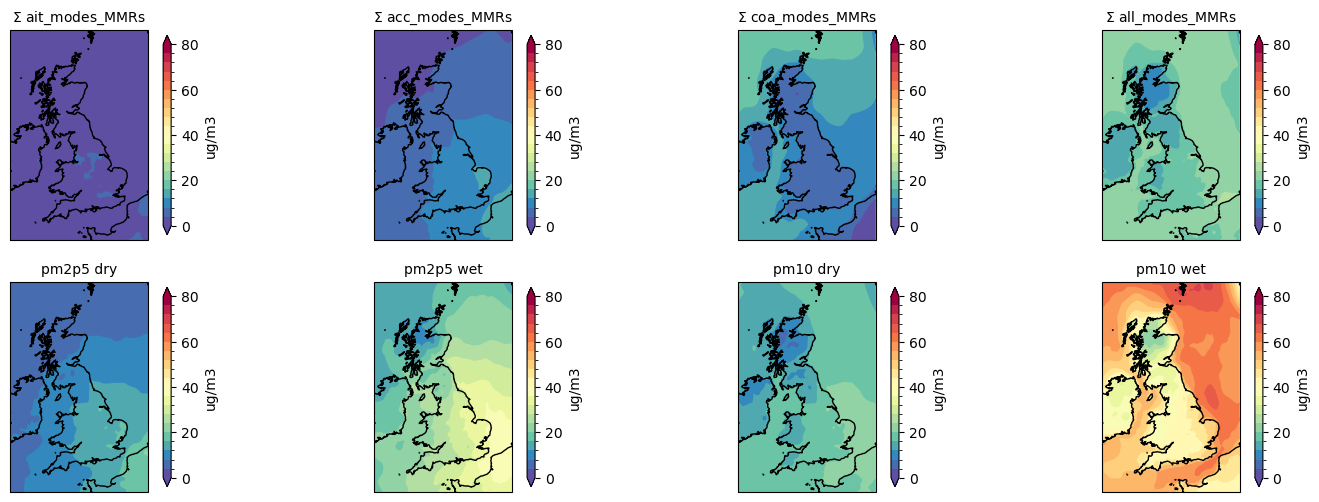

In [5]:
fig = plt.figure(figsize=(18,6), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

cmap = plt.get_cmap("Spectral")
cmap_r = cmap.reversed()
cmap = cmap_r

#   Fig 1   #
plt.subplot(2, 4, 1)

"""
cb_min=1e3
cb_max=1e-2
norm = norm = LogNorm(cb_min, cb_max)
cb_label_str = 'ug/m3'

iplt.pcolormesh(extract_modes_ait.collapsed(['time'],iris.analysis.MEAN),
              cmap=cmap, 
              norm=norm)

plt.colorbar(orientation='vertical',
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("sum ait species in modes mmr", fontsize=10, linespacing=1.2)
"""

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_modes_ait.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("$\Sigma$ ait_modes_MMRs", fontsize=10, linespacing=1.2)


#   Fig 2   #
plt.subplot(2, 4, 2)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_modes_acc.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("$\Sigma$ acc_modes_MMRs", fontsize=10, linespacing=1.2)


#   Fig 3   #
plt.subplot(2, 4, 3)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_modes_coa.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("$\Sigma$ coa_modes_MMRs", fontsize=10, linespacing=1.2)


#   Fig 4   #
plt.subplot(2, 4, 4)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_modes_all.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("$\Sigma$ all_modes_MMRs", fontsize=10, linespacing=1.2)


#   Fig 5   #
plt.subplot(2, 4, 5)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_pm2p5dry.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("pm2p5 dry", fontsize=10, linespacing=1.2)

#   Fig 6   #
plt.subplot(2, 4, 6)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_pm2p5wet.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("pm2p5 wet", fontsize=10, linespacing=1.2)

#   Fig 7   #
plt.subplot(2, 4, 7)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_pm10dry.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("pm10 dry", fontsize=10, linespacing=1.2)

#   Fig 8   #
plt.subplot(2, 4, 8)

cb_min=0
cb_max=80
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_pm10wet.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("pm10 wet", fontsize=10, linespacing=1.2)



Text(0, 0.5, 'pm2.5 wet [ug/m3]')

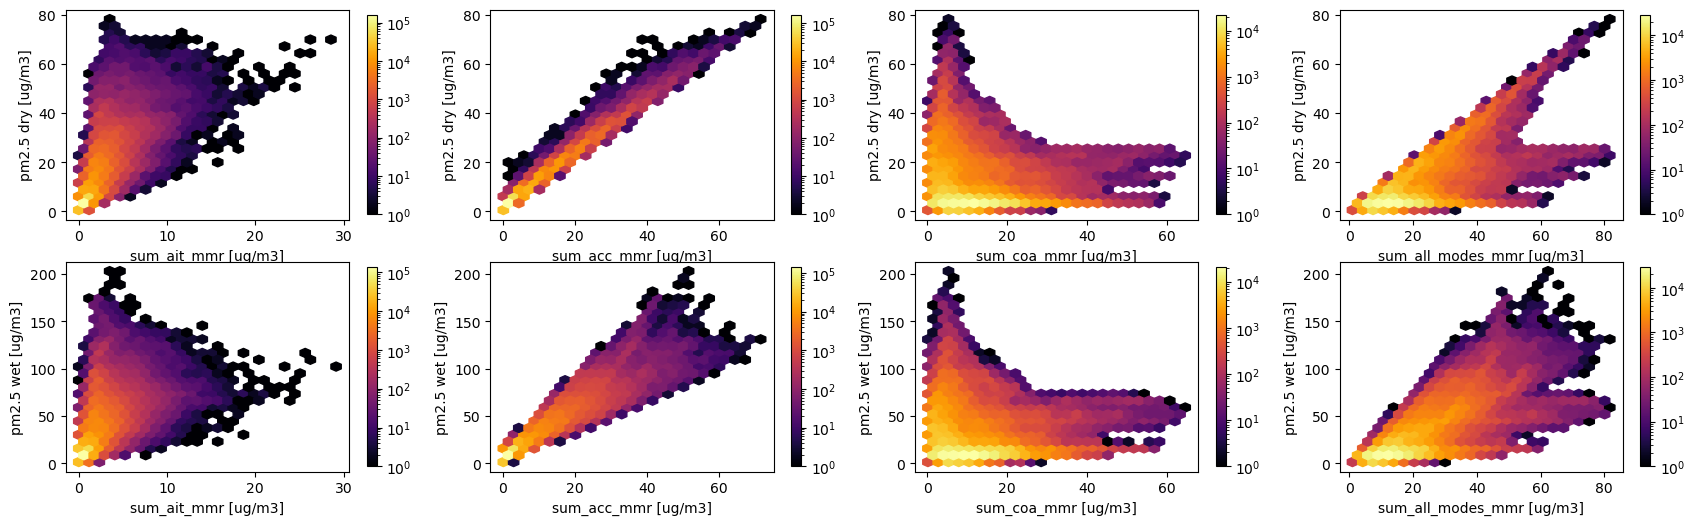

In [6]:
fig = plt.figure(figsize=(21,6), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

cmap = plt.get_cmap("Spectral")
cmap_r = cmap.reversed()
cmap = cmap_r


#   Fig 1   #
plt.subplot(2, 4, 1)

x_1D = extract_modes_ait.data.reshape(-1, 1)
y_1D = extract_pm2p5dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")


#   Fig 2   #
plt.subplot(2, 4, 2)

x_1D = extract_modes_acc.data.reshape(-1, 1)
y_1D = extract_pm2p5dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")


#   Fig 3   #
plt.subplot(2, 4, 3)

x_1D = extract_modes_coa.data.reshape(-1, 1)
y_1D = extract_pm2p5dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")


#   Fig 4   #
plt.subplot(2, 4, 4)

x_1D = extract_modes_all.data.reshape(-1, 1)
y_1D = extract_pm2p5dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_all_modes_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")



#   Fig 5   #
plt.subplot(2, 4, 5)

x_1D = extract_modes_ait.data.reshape(-1, 1)
y_1D = extract_pm2p5wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 wet [ug/m3]")


#   Fig 6   #
plt.subplot(2, 4, 6)

x_1D = extract_modes_acc.data.reshape(-1, 1)
y_1D = extract_pm2p5wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 wet [ug/m3]")


#   Fig 7   #
plt.subplot(2, 4, 7)

x_1D = extract_modes_coa.data.reshape(-1, 1)
y_1D = extract_pm2p5wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 wet [ug/m3]")


#   Fig 8   #
plt.subplot(2, 4, 8)

x_1D = extract_modes_all.data.reshape(-1, 1)
y_1D = extract_pm2p5wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_all_modes_mmr [ug/m3]")
plt.ylabel("pm2.5 wet [ug/m3]")


#plt.show()

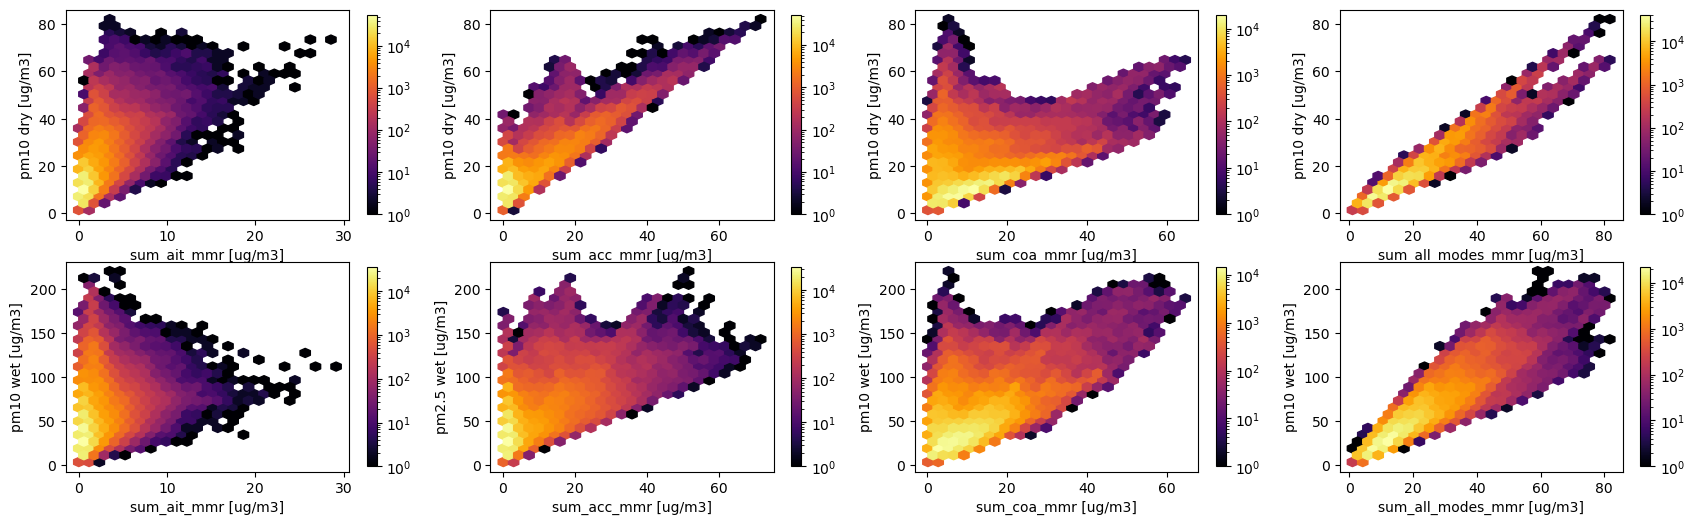

In [7]:
fig = plt.figure(figsize=(21,6), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

cmap = plt.get_cmap("Spectral")
cmap_r = cmap.reversed()
cmap = cmap_r


#   Fig 1   #
plt.subplot(2, 4, 1)

x_1D = extract_modes_ait.data.reshape(-1, 1)
y_1D = extract_pm10dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm10 dry [ug/m3]")


#   Fig 2   #
plt.subplot(2, 4, 2)

x_1D = extract_modes_acc.data.reshape(-1, 1)
y_1D = extract_pm10dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm10 dry [ug/m3]")


#   Fig 3   #
plt.subplot(2, 4, 3)

x_1D = extract_modes_coa.data.reshape(-1, 1)
y_1D = extract_pm10dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm10 dry [ug/m3]")


#   Fig 4   #
plt.subplot(2, 4, 4)

x_1D = extract_modes_all.data.reshape(-1, 1)
y_1D = extract_pm10dry.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_all_modes_mmr [ug/m3]")
plt.ylabel("pm10 dry [ug/m3]")



#   Fig 5   #
plt.subplot(2, 4, 5)

x_1D = extract_modes_ait.data.reshape(-1, 1)
y_1D = extract_pm10wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm10 wet [ug/m3]")


#   Fig 6   #
plt.subplot(2, 4, 6)

x_1D = extract_modes_acc.data.reshape(-1, 1)
y_1D = extract_pm10wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 wet [ug/m3]")


#   Fig 7   #
plt.subplot(2, 4, 7)

x_1D = extract_modes_coa.data.reshape(-1, 1)
y_1D = extract_pm10wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm10 wet [ug/m3]")


#   Fig 8   #
plt.subplot(2, 4, 8)

x_1D = extract_modes_all.data.reshape(-1, 1)
y_1D = extract_pm10wet.data.reshape(-1, 1)

plt.hexbin(x_1D, y_1D, gridsize=25, bins='log', cmap='inferno')
plt.colorbar(orientation='vertical',
             shrink=sh)
plt.xlabel("sum_all_modes_mmr [ug/m3]")
plt.ylabel("pm10 wet [ug/m3]")


plt.show()

## Load ALL data

In [8]:
"""
# Define the features/predictors to be fitted:
x1_1D = extract_modes_ait.data.reshape(-1, 1)
x2_1D = extract_modes_acc.data.reshape(-1, 1)
x3_1D = extract_modes_coa.data.reshape(-1, 1)
x4_1D = extract_rhw.data.reshape(-1, 1)
x5_1D = extract_ait_ins_number.data.reshape(-1, 1)
x6_1D = extract_coa_sol_number.data.reshape(-1, 1)
x7_1D = extract_acc_sol_number.data.reshape(-1, 1)
x8_1D = extract_ait_sol_number.data.reshape(-1, 1)
x_1D = np.hstack((x1_1D, x2_1D, x3_1D, x4_1D, x5_1D, x6_1D, x7_1D, x8_1D))
x_1D = np.hstack((x1_1D, x2_1D, x3_1D,        x5_1D, x6_1D, x7_1D, x8_1D))
print(x_1D.shape)

#x_1D = np.stack((x1_1D, x2_1D, x3_1D), axis = 3)
#print(x1_1D.shape)

# Define the Target to be fitted:
y_1D = extract_pm2p5dry.data.reshape(-1, 1)
#y_1D = extract_pm2p5wet.data.reshape(-1, 1)
#y_1D = extract_pm10dry.data.reshape(-1, 1)
#y_1D = extract_pm10wet.data.reshape(-1, 1)
print(y_1D.shape)

# Convert to PyTorch tensors
x_train = torch.tensor(x_1D[:], dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_1D[:], dtype=torch.float32).unsqueeze(1)
#x_train = torch.tensor(x_1D, dtype=torch.float32)
#y_train = torch.tensor(y_1D, dtype=torch.float32)
print(x_train.shape)
print(y_train.shape)
"""

'\n# Define the features/predictors to be fitted:\nx1_1D = extract_modes_ait.data.reshape(-1, 1)\nx2_1D = extract_modes_acc.data.reshape(-1, 1)\nx3_1D = extract_modes_coa.data.reshape(-1, 1)\nx4_1D = extract_rhw.data.reshape(-1, 1)\nx5_1D = extract_ait_ins_number.data.reshape(-1, 1)\nx6_1D = extract_coa_sol_number.data.reshape(-1, 1)\nx7_1D = extract_acc_sol_number.data.reshape(-1, 1)\nx8_1D = extract_ait_sol_number.data.reshape(-1, 1)\nx_1D = np.hstack((x1_1D, x2_1D, x3_1D, x4_1D, x5_1D, x6_1D, x7_1D, x8_1D))\nx_1D = np.hstack((x1_1D, x2_1D, x3_1D,        x5_1D, x6_1D, x7_1D, x8_1D))\nprint(x_1D.shape)\n\n#x_1D = np.stack((x1_1D, x2_1D, x3_1D), axis = 3)\n#print(x1_1D.shape)\n\n# Define the Target to be fitted:\ny_1D = extract_pm2p5dry.data.reshape(-1, 1)\n#y_1D = extract_pm2p5wet.data.reshape(-1, 1)\n#y_1D = extract_pm10dry.data.reshape(-1, 1)\n#y_1D = extract_pm10wet.data.reshape(-1, 1)\nprint(y_1D.shape)\n\n# Convert to PyTorch tensors\nx_train = torch.tensor(x_1D[:], dtype=torch.f

## Load data and split into tain, validation, and verif datasets

In [18]:
print(extract_modes_ait.data.shape)

# define size of train/eval/infer dataset (in percent) 
pc_val = 0.1
pc_inf = 0.025
pc_train = 1 - pc_inf - pc_val 

# Define the features/predictors to be fitted:
x1 = extract_modes_ait.data.reshape(-1)
x2 = extract_modes_acc.data.reshape(-1)
x3 = extract_modes_coa.data.reshape(-1)
x4 = extract_rhw.data.reshape(-1)
x5 = extract_ait_ins_number.data.reshape(-1)
x6 = extract_coa_sol_number.data.reshape(-1)
x7 = extract_acc_sol_number.data.reshape(-1)
x8 = extract_ait_sol_number.data.reshape(-1)

x1train_dataset, x1val_dataset, x1infer_dataset = split(x1, pc_val, pc_inf, 42)
x2train_dataset, x2val_dataset, x2infer_dataset = split(x2, pc_val, pc_inf, 42)
x3train_dataset, x3val_dataset, x3infer_dataset = split(x3, pc_val, pc_inf, 42)
x4train_dataset, x4val_dataset, x4infer_dataset = split(x4, pc_val, pc_inf, 42)
x5train_dataset, x5val_dataset, x5infer_dataset = split(x5, pc_val, pc_inf, 42)
x6train_dataset, x6val_dataset, x6infer_dataset = split(x6, pc_val, pc_inf, 42)
x7train_dataset, x7val_dataset, x7infer_dataset = split(x7, pc_val, pc_inf, 42)
x8train_dataset, x8val_dataset, x8infer_dataset = split(x8, pc_val, pc_inf, 42)

print(f"full_dataset:{len(x1)}") # length of the train division
print(f"train_dataset:{len(x1train_dataset)}") # length of the train division
print(f"xval_dataset:{len(x1val_dataset)}") # length of the validation division
print(f"xinfer_dataset:{len(x1infer_dataset)}") # length of the infer division

xt = np.stack(
    (x1train_dataset,
     x2train_dataset,
     x3train_dataset,
     x5train_dataset,
     x6train_dataset,
     x7train_dataset,
     x8train_dataset), axis=1)
xv = np.stack(
    (x1val_dataset,
     x2val_dataset,
     x3val_dataset,
     x5val_dataset,
     x6val_dataset,
     x7val_dataset,
     x8val_dataset), axis=1)
xi = np.stack(
    (x1infer_dataset,
     x2infer_dataset,
     x3infer_dataset,
     x5infer_dataset,
     x6infer_dataset,
     x7infer_dataset,
     x8infer_dataset), axis=1)

print(f"xt.shape:{xt.shape}")

# Define the Target array to be fitted:
y = extract_pm2p5dry.data.reshape(-1)
#y = extract_pm2p5wet.data.reshape(-1)
#y = extract_pm10dry.data.reshape(-1)
#y = extract_pm10wet.data.reshape(-1)

ytrain_dataset, yval_dataset, yinfer_dataset = split(y, pc_val, pc_inf, 42)
yt = np.stack(ytrain_dataset)
yv = np.stack(yval_dataset)
yi = np.stack(yinfer_dataset)
print(f"yt.shape:{yt.shape}")

# convert into tensors
x_train = torch.Tensor(xt).reshape(-1, 7)
y_train = torch.Tensor(yt).reshape(-1, 1)
x_val = torch.Tensor(xv).reshape(-1, 7)
y_val = torch.Tensor(yv).reshape(-1, 1)
x_infer = torch.Tensor(xi).reshape(-1, 7)
y_infer = torch.Tensor(yi).reshape(-1, 1)
print(f"tensor x: {x_train.shape}")
print(f"tensor y: {y_train.shape}")

# create tensor dataset
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
infer_dataset = TensorDataset(x_infer, y_infer)

# define batch size and batch steps
batch_size = 2500
training_steps = len(y_train) // batch_size
validation_steps = len(y_val) // batch_size

print(f"batch_size ={batch_size}")
print(f"train_data_size = {len(y_train)}")
print(f"training_steps = {training_steps}")
print(f"val_data_size = {len(y_val)}")
print(f"validation_steps = {validation_steps}")

#load into dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
infer_loader = DataLoader(infer_dataset, batch_size=batch_size, shuffle=True)

(59, 106, 70)
full_dataset:437780
train_dataset:383058
xval_dataset:43778
xinfer_dataset:10944
xt.shape:(383058, 7)
yt.shape:(383058,)
tensor x: torch.Size([383058, 7])
tensor y: torch.Size([383058, 1])
batch_size =2500
train_data_size = 383058
training_steps = 153
val_data_size = 43778
validation_steps = 17


## Initiate NN model

In [19]:
# Define the model
class PM_Net(nn.Module):
    def __init__(self):
        super(PM_Net, self).__init__()
        #self.fc1 = nn.Linear(7, 100)
        self.fc1 = nn.Linear(7, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialise model
model = PM_Net()

## Training loop

In [20]:
# Number of learning iterations.
# Note: If the model is not reinitialised, it will continue training from 
# where last execution of this cell ended.
epochs = 100

# Store losses
train_loss = []
val_loss = []

# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    
    # Training step
    total_loss = 0
    
    for id_batch, (xt_batch, yt_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        ypred = model(xt_batch)
        loss = criterion(ypred, yt_batch)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    train_loss.append(total_loss / training_steps)

    # Validation step
    total_loss = 0      
    
    for id_batch, (xv_batch, yv_batch) in enumerate(val_loader):
        ypred = model(xv_batch)
        vloss = criterion(ypred, yv_batch)
        total_loss += vloss.item()
        
    val_loss.append(total_loss / validation_steps)  
    
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{epochs}] - Training Loss: {train_loss[epoch]:.4f} - Validation Loss: {val_loss[epoch]:.4f}')

Epoch [1/100] - Training Loss: 51.7705 - Validation Loss: 1.1093
Epoch [2/100] - Training Loss: 0.4682 - Validation Loss: 0.1926
Epoch [3/100] - Training Loss: 0.1717 - Validation Loss: 0.1725
Epoch [4/100] - Training Loss: 0.1568 - Validation Loss: 0.1534
Epoch [5/100] - Training Loss: 0.1423 - Validation Loss: 0.1469
Epoch [6/100] - Training Loss: 0.1390 - Validation Loss: 0.1446
Epoch [7/100] - Training Loss: 0.1375 - Validation Loss: 0.1440
Epoch [8/100] - Training Loss: 0.1364 - Validation Loss: 0.1428
Epoch [9/100] - Training Loss: 0.1355 - Validation Loss: 0.1420
Epoch [10/100] - Training Loss: 0.1350 - Validation Loss: 0.1415
Epoch [11/100] - Training Loss: 0.1344 - Validation Loss: 0.1405
Epoch [12/100] - Training Loss: 0.1340 - Validation Loss: 0.1406
Epoch [13/100] - Training Loss: 0.1338 - Validation Loss: 0.1405
Epoch [14/100] - Training Loss: 0.1334 - Validation Loss: 0.1399
Epoch [15/100] - Training Loss: 0.1331 - Validation Loss: 0.1395
Epoch [16/100] - Training Loss: 0

## Plot Loss and save model weights

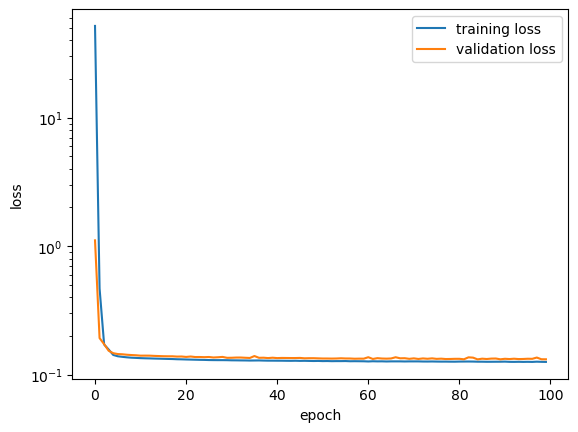

Model's state_dict:
fc1.weight 	 torch.Size([50, 7])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([50, 50])
fc2.bias 	 torch.Size([50])
fc3.weight 	 torch.Size([1, 50])
fc3.bias 	 torch.Size([1])


In [21]:
fig = plt.figure()
plt.plot(np.arange(epochs),train_loss,label="training loss")
plt.plot(np.arange(epochs),val_loss,label="validation loss")
#plt.plot(train_loss,label="training loss")
#plt.plot(val_loss,label="validation loss")
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

# Saving the model
torch.save(model.state_dict(), "PM2p5_model.NN")

## Evaluation / Inference

In [22]:
# Evaluate the model (Inference)
model.eval()

# use features not seen in the training
x2 = xi[0:6000,:]
y2 = yi[0:6000]

x_test = torch.tensor(x2, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    predicted = model(x_test).detach().numpy()

print(f"x2.shape: {x2.shape}")
print(f"y2.shape: {y2.shape}")
print(f"predicted.shape: {predicted.shape}")

x2_mean = np.mean(x2)
y2_mean = np.mean(y2)
print(f"x2 mean = {x2_mean}")
print(f"y2 mean = {y2_mean}")

predicted_mean = np.mean(predicted)
print(f"predicted mean = {predicted_mean}")

diff = np.squeeze(predicted) - np.squeeze(y2)
print(f"diff.shape: {diff.shape}")

x2.shape: (6000, 7)
y2.shape: (6000,)
predicted.shape: (6000, 1, 1)
x2 mean = 2.7888598442077637
y2 mean = 9.425506591796875
predicted mean = 9.420482635498047
diff.shape: (6000,)


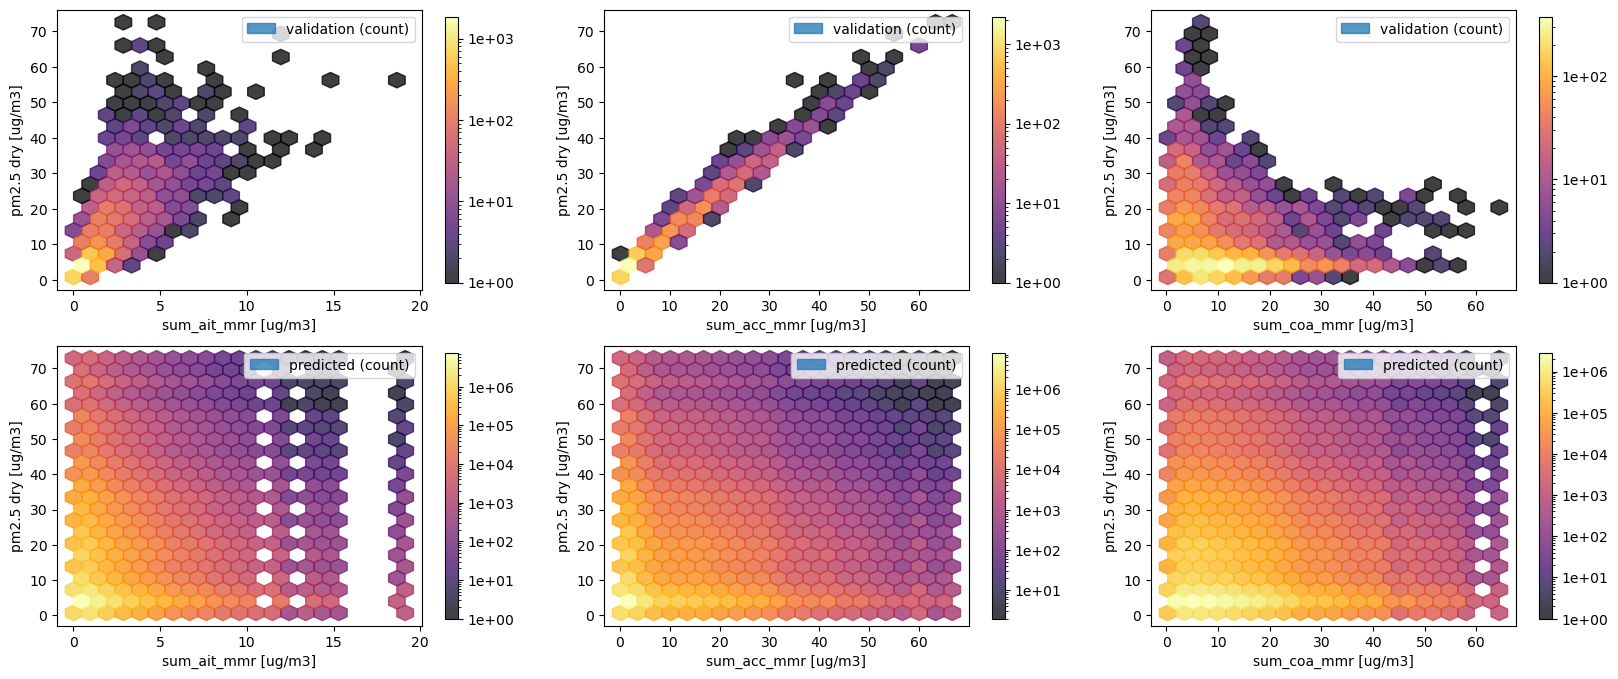

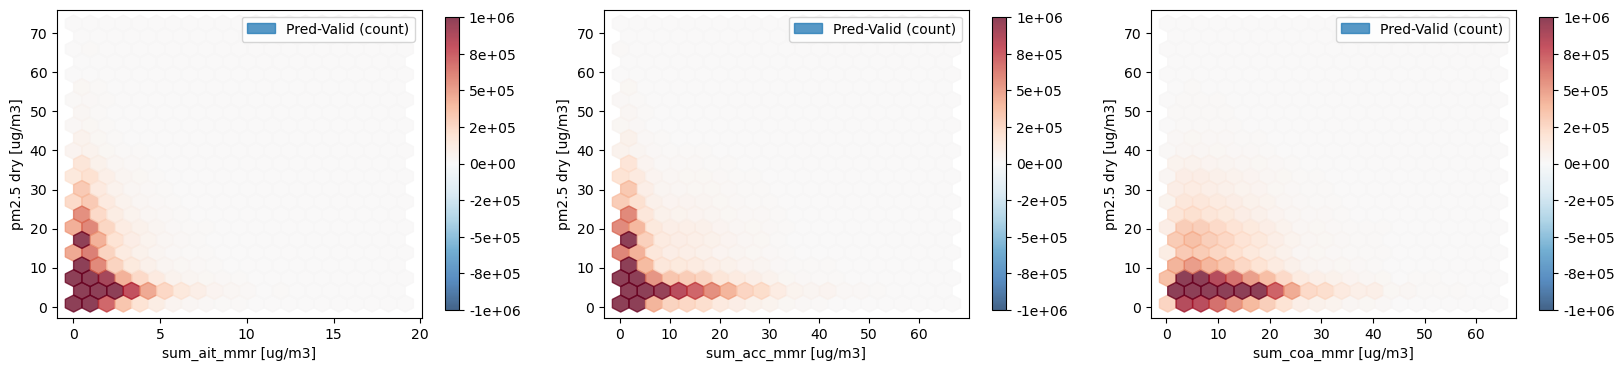

In [23]:
#########################################
fig = plt.figure(figsize=(20,8), dpi=100)
#########################################

plt.subplot(2, 3, 1)
#h1 = plt.hexbin(x2[:,0], y2, label='validation', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h1 = plt.hexbin(x2[:,0], y2, label='validation (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(2, 3, 2)
#h2 = plt.hexbin(x2[:,1], y2, label='validation', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h2 = plt.hexbin(x2[:,1], y2, label='validation (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(2, 3, 3)
#h3 = plt.hexbin(x2[:,2], y2, label='validation', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h3 = plt.hexbin(x2[:,2], y2, label='validation (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(2, 3, 4)
#h4 = plt.hexbin(x2[:,0], predicted, label='predicted', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h4 = plt.hexbin(x2[:,0], predicted, label='predicted (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(2, 3, 5)
#h5 = plt.hexbin(x2[:,1], predicted, label='predicted', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h5 = plt.hexbin(x2[:,1], predicted, label='predicted (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(2, 3, 6)
#h6 = plt.hexbin(x2[:,2], predicted, label='predicted', alpha=0.75, gridsize=100, bins='log', cmap='inferno')
h6 = plt.hexbin(x2[:,2], predicted, label='predicted (count)', alpha=0.75, gridsize=20, bins='log', cmap='inferno')
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')



#########################################
fig = plt.figure(figsize=(20,4), dpi=100)
#########################################

plt.subplot(1, 3, 1)
h1d = plt.hexbin(x2[:,0], y2, label='Pred-Valid (count)', alpha=0.75, gridsize=20, vmin=-1e6, vmax=1e6, cmap='RdBu_r')
h1d.set_array(h4.get_array()-h1.get_array())
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(1, 3, 2)
h2d = plt.hexbin(x2[:,1], y2, label='Pred-Valid (count)', alpha=0.75, gridsize=20, vmin=-1e6, vmax=1e6, cmap='RdBu_r')
h2d.set_array(h5.get_array()-h2.get_array())
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')

plt.subplot(1, 3, 3)
h3d = plt.hexbin(x2[:,2], y2, label='Pred-Valid (count)', alpha=0.75, gridsize=20, vmin=-1e6, vmax=1e6, cmap='RdBu_r')
h3d.set_array(h6.get_array()-h3.get_array())
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()
plt.colorbar(shrink=sh,
             format='%.0e')


plt.show()

(6000, 7)
(6000,)


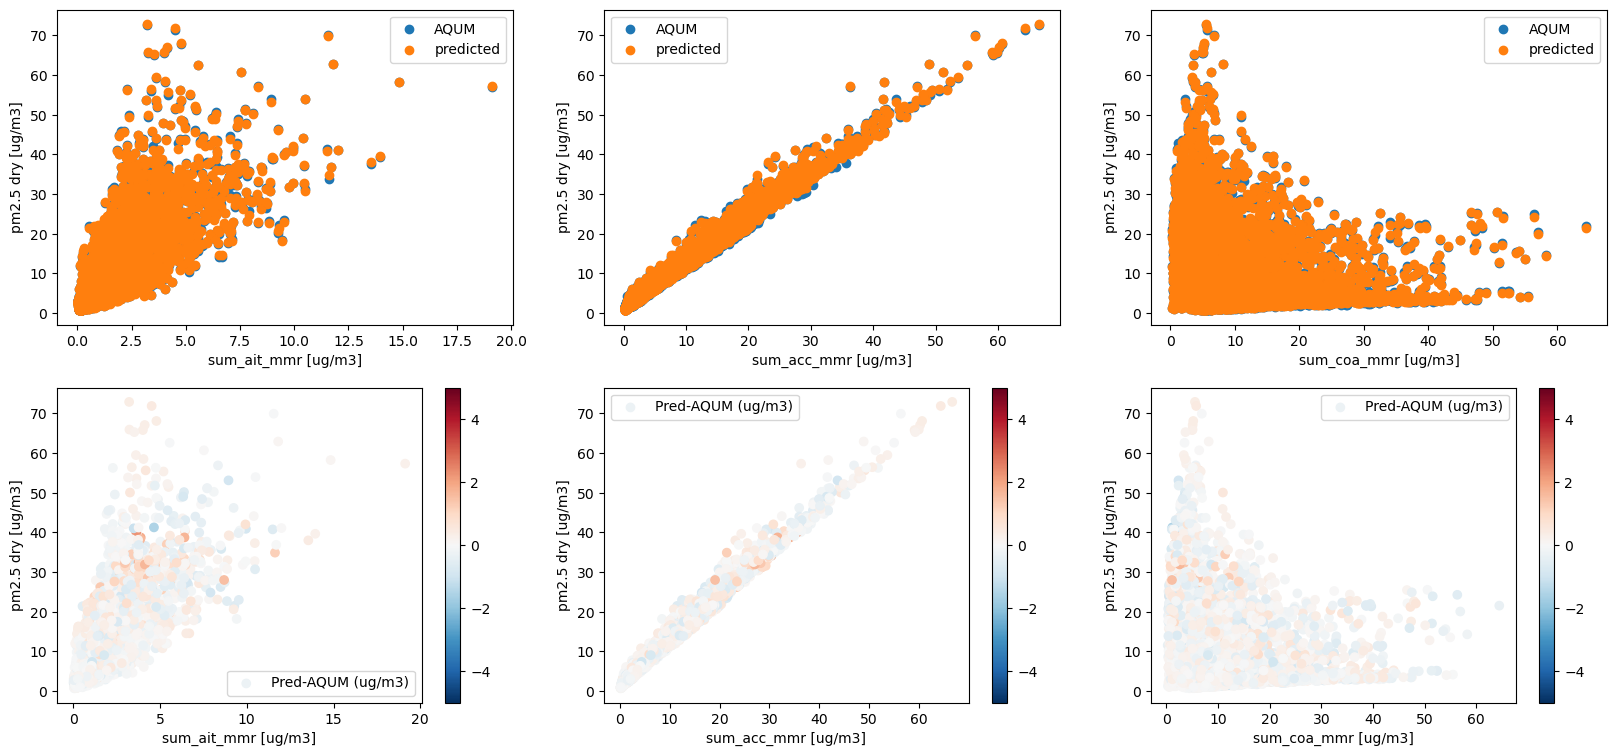

In [24]:
#########################################
fig = plt.figure(figsize=(20,9), dpi=100)
#########################################

print(x2.shape)
print(y2.shape)

plt.subplot(2, 3, 1)
plt.scatter(x2[:,0], y2, label='AQUM')
plt.scatter(x2[:,0], predicted, label='predicted')
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()

plt.subplot(2, 3, 2)
plt.scatter(x2[:,1], y2, label='AQUM')
plt.scatter(x2[:,1], predicted, label='predicted')
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()

plt.subplot(2, 3, 3)
plt.scatter(x2[:,2], y2, label='AQUM')
plt.scatter(x2[:,2], predicted, label='predicted')
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.legend()

plt.subplot(2, 3, 4)
plt.scatter(x2[:,0], predicted, c=diff, label='Pred-AQUM (ug/m3)', cmap='RdBu_r',vmin=-5,vmax=5)
plt.xlabel("sum_ait_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.colorbar()
plt.legend()

plt.subplot(2, 3, 5)
plt.scatter(x2[:,1], predicted, c=diff, label='Pred-AQUM (ug/m3)', cmap='RdBu_r',vmin=-5,vmax=5)
plt.xlabel("sum_acc_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.colorbar()
plt.legend()

plt.subplot(2, 3, 6)
plt.scatter(x2[:,2], predicted, c=diff, label='Pred-AQUM (ug/m3)', cmap='RdBu_r',vmin=-5,vmax=5)
plt.xlabel("sum_coa_mmr [ug/m3]")
plt.ylabel("pm2.5 dry [ug/m3]")
plt.colorbar()
plt.legend()


plt.show()

## Loading Trained PM Model

In [25]:
NN_pm2p5dry = extract_pm2p5dry.copy()
NN_pm2p5wet = extract_pm2p5wet.copy()
NN_pm10dry = extract_pm10dry.copy()
NN_pm10wet = extract_pm10wet.copy()

dt, dx, dy = NN_pm2p5dry.data.shape
print(f"{NN_pm2p5dry.data.shape}")

for i in range(dt):
    for j in range(dx):
        for k in range(dy):
            # Define the features/predictors to be used:
            x1_1D = extract_modes_ait.data[i,j,k].reshape(-1, 1)
            x2_1D = extract_modes_acc.data[i,j,k].reshape(-1, 1)
            x3_1D = extract_modes_coa.data[i,j,k].reshape(-1, 1)
            #x4_1D = extract_rhw.data[i,j,k].reshape(-1, 1)
            x5_1D = extract_ait_ins_number.data[i,j,k].reshape(-1, 1)
            x6_1D = extract_coa_sol_number.data[i,j,k].reshape(-1, 1)
            x7_1D = extract_acc_sol_number.data[i,j,k].reshape(-1, 1)
            x8_1D = extract_ait_sol_number.data[i,j,k].reshape(-1, 1)
            #x_1D = np.hstack((x1_1D, x2_1D, x3_1D, x4_1D, x5_1D, x6_1D, x7_1D, x8_1D))
            x_1D = np.hstack((x1_1D, x2_1D, x3_1D,         x5_1D, x6_1D, x7_1D, x8_1D))
            x_array = torch.tensor(x_1D, dtype=torch.float32).unsqueeze(1)
            #print(f"x_array = {x_array}")
            
            with torch.no_grad():
                NN_pm2p5dry.data[i,j,k] = model(x_array).detach().numpy()
                NN_pm2p5wet.data[i,j,k] = model(x_array).detach().numpy()
                NN_pm10dry.data[i,j,k] = model(x_array).detach().numpy()
                NN_pm10wet.data[i,j,k] = model(x_array).detach().numpy()
                #print(f"{NN_pm2p5dry.data[i,j,k]} / {extract_pm2p5dry.data[i,j,k]}")

(59, 106, 70)


## Plot AQUM PM diag vs NN estimates

Text(0.5, 1.0, 'AQUM pm2p5 dry')

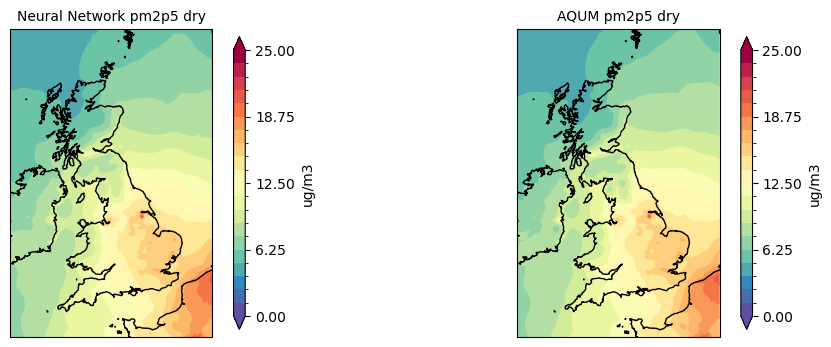

In [26]:
fig = plt.figure(figsize=(12,4), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

cmap = plt.get_cmap("Spectral")
cmap_r = cmap.reversed()
cmap = cmap_r

# PM Neural Network
#   Fig 1   #
plt.subplot(1, 2, 1)

cb_min=0
cb_max=25
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(NN_pm2p5dry.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("Neural Network pm2p5 dry", fontsize=10, linespacing=1.2)


# PM MODEL DIAG
#   Fig 2   #
plt.subplot(1, 2, 2)

cb_min=0
cb_max=25
levels = np.linspace(cb_min, cb_max, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
tick_lvl = levels[0::5]
cb_label_str = 'ug/m3'

iplt.contourf(extract_pm2p5dry.collapsed(['time'],iris.analysis.MEAN),
              levels=levels,
              cmap=cmap, 
              norm=norm,
              extend='both')

plt.colorbar(orientation='vertical',
             ticks=tick_lvl,
             # format="%.1e",
             pad=pad,
             aspect=asp,
             shrink=sh).set_label(cb_label_str)

plt.gca().coastlines(resolution='10m')
plt.title("AQUM pm2p5 dry", fontsize=10, linespacing=1.2)